# 实验步骤：
1.	数据集获取
2.	导入实验环境
3.	读取数据集
4.	模型构建训练
5.	模型预测
6.	模型保存和转换

## 1. 数据集获取

该数据集是开源数据集，总共包括5种花的类型：分别是daisy（雏菊，633张），dandelion（蒲公英，898张），roses（玫瑰，641张），sunflowers（向日葵，699张），tulips（郁金香，799张），保存在5个文件夹当中，总共3670张，大小大概在230M左右。为了在模型部署上线之后进行测试，数据集在这里分成了flower_train和flower_test两部分。


在ModelArts平台输入代码自动获取数据，获取后的数据会存在当前项目的work目录下，不会同步到OBS，如果想要查看下载的文件，可以调用终端，输入cd work命令，切换到work目录下之后，输入ls命令进行查看。


In [1]:
#ModelArts平台输入代码会自动下载数据，下载完成之后不需要二次运行，不然会报错。
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_train.zip
!unzip flower_photos_train.zip
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip
!unzip flower_photos_test.zip 



--2021-06-21 01:58:06--  https://professional.obs.cn-north-4.myhuaweicloud.com/flower_photos_train.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 226761752 (216M) [application/zip]
Saving to: ‘flower_photos_train.zip’

flower_photos_train 100%[===================>] 216.26M   187MB/s    in 1.2s    

2021-06-21 01:58:07 (187 MB/s) - ‘flower_photos_train.zip’ saved [226761752/226761752]

Archive:  flower_photos_train.zip
   creating: flower_photos_train/
   creating: flower_photos_train/daisy/
  inflating: flower_photos_train/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos_train/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos_train/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos_train/daisy/10172636503

In [2]:
# 隐藏警告
import warnings
warnings.filterwarnings('ignore')

## 2. 导入实验环境

### 步骤 1	导入相应的模块

os模块主要用于处理文件和目录，比如：获取当前目录下文件，删除制定文件，改变目录，查看文件大小等；MindSpore是目前业界最流行的深度学习框架，在图像，语音，文本，目标检测等领域都有深入的应用，也是该实验的核心，主要用于定义占位符，定义变量，创建卷积神经网络模型；numpy是一个基于python的科学计算包，在该实验中主要用来处理数值运算。

In [3]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#os模块主要用于处理文件和目录
import os

import numpy as np
import matplotlib.pyplot as plt

import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops

# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")


### 步骤 2	定义变量

In [4]:
cfg = edict({
    'data_path': 'flower_photos_train',   #训练数据集，如果是zip文件需要解压
    'test_path':'flower_photos_test',     #测试数据集，如果是zip文件需要解压
    'data_size': 3616,
    'HEIGHT': 224,  # 图片高度
    'WIDTH': 224,  # 图片宽度
    '_R_MEAN': 123.68,
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1,
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256,
    '_RESIZE_SIDE_MAX': 512,
    
    'batch_size': 32,
    'num_class': 5,     # 分类类别
    'epoch_size': 150,  # 训练次数
    'loss_scale_num':1024,
    
    'prefix': 'resnet-ai',
    'directory': './model_resnet',
    'save_checkpoint_steps': 10,
})


## 3. 读取数据集
数据读取并处理流程如下：

MindSpore的mindspore.dataset提供了ImageFolderDataset函数，可以直接读取文件夹图片数据并映射文件夹名字为其标签(label)。这里我们使用ImageFolderDataset函数读取'daisy','dandelion','roses','sunflowers','tulips'数据。并将这五类标签映射为：{'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}，使用RandomCropDecodeResize、HWC2CHW、shuffle进行数据预处理。


训练数据集数量： 3616
测试数据集数量： 52
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 1


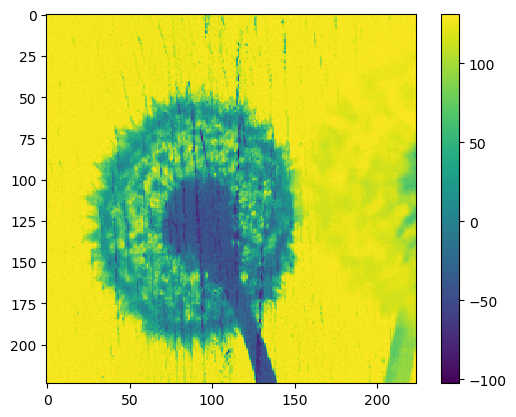

In [5]:
# 数据处理
def read_data(path,config,usage="train"):
    #从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
    # define map operations
    decode_op = vision.Decode()
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    horizontal_flip_op = vision.RandomHorizontalFlip()
    channelswap_op = vision.HWC2CHW()
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    dataset = dataset.repeat(1)
    dataset.map_model = 4

    return dataset
   
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size())


de_dataset = de_train
data_next = de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)
print('一张图像的标签样式：', data_next['label'][0])  # 一共5类，用0-4的数字表达类别。

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


## 4. 模型构建训练
搭建ResNet50神经网络模型
### 步骤 1	定义模型

In [6]:
"""ResNet."""
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)


class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])
        self.add = ops.Add()

    def construct(self, x): # pylint: disable=missing-docstring
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    def construct(self, x): # pylint: disable=missing-docstring
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out


def resnet50(class_num=10):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)


def resnet101(class_num=1001):
    """
    Get ResNet101 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet101 neural network.

    Examples:
        >>> net = resnet101(1001)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 23, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)


### 步骤 2	自定义动态学习率

In [7]:
def get_lr(global_step,
           total_epochs,
           steps_per_epoch,
           lr_init=0.01,
           lr_max=0.1,
           warmup_epochs=5):
    """
    Generate learning rate array.

    Args:
        global_step (int): Initial step of training.
        total_epochs (int): Total epoch of training.
        steps_per_epoch (float): Steps of one epoch.
        lr_init (float): Initial learning rate. Default: 0.01.
        lr_max (float): Maximum learning rate. Default: 0.1.
        warmup_epochs (int): The number of warming up epochs. Default: 5.

    Returns:
        np.array, learning rate array.
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    if warmup_steps != 0:
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
    else:
        inc_each_step = 0
    for i in range(int(total_steps)):
        if i < warmup_steps:
            lr = float(lr_init) + inc_each_step * float(i)
        else:
            base = ( 1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)) )
            lr = float(lr_max) * base * base
            if lr < 0.0:
                lr = 0.0
        lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


### 步骤 3	开始训练
完成数据预处理、网络定义、损失函数和优化器定义之后，开始模型训练。模型训练包含2层迭代，数据集的多伦迭代epoch和一轮数据集内按分组从数据集中抽取数据，输入网络计算得到损失函数，然后通过优化器计算和更新训练参数的梯度。


In [8]:
net=resnet50(class_num=cfg.num_class)
#计算softmax交叉熵。
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#设置Adam优化器
train_step_size = de_train.get_dataset_size()
lr = Tensor(get_lr(global_step=0, total_epochs=cfg.epoch_size, steps_per_epoch=train_step_size))
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)
#opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.002,
#                       0.9, 0.00004, loss_scale=1024.0)
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})
loss_cb = LossMonitor(per_print_times=train_step_size)
ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)


============== Starting Training ==============
epoch: 1 step: 113, loss is 1.7479601
epoch: 2 step: 113, loss is 1.6090293
epoch: 3 step: 113, loss is 1.1715947
epoch: 4 step: 113, loss is 0.96505964
epoch: 5 step: 113, loss is 1.1993613
epoch: 6 step: 113, loss is 0.916652
epoch: 7 step: 113, loss is 0.7374598
epoch: 8 step: 113, loss is 0.9027816
epoch: 9 step: 113, loss is 0.75773644
epoch: 10 step: 113, loss is 0.7568343
epoch: 11 step: 113, loss is 0.6980962
epoch: 12 step: 113, loss is 0.5661331
epoch: 13 step: 113, loss is 0.79389155
epoch: 14 step: 113, loss is 0.5994663
epoch: 15 step: 113, loss is 0.53099114
epoch: 16 step: 113, loss is 0.53870714
epoch: 17 step: 113, loss is 0.56631553
epoch: 18 step: 113, loss is 0.80407333
epoch: 19 step: 113, loss is 0.36333305
epoch: 20 step: 113, loss is 0.6664077
epoch: 21 step: 113, loss is 0.7632055
epoch: 22 step: 113, loss is 0.89789414
epoch: 23 step: 113, loss is 0.7269038
epoch: 24 step: 113, loss is 0.56401855
epoch: 25 step: 

### 步骤 4	模型评估

In [9]:
# 使用测试集评估模型，打印总体准确率
metric = model.eval(de_test)
print(metric)


{'acc': 0.9423076923076923}


## 5. 模型预测

In [10]:
# 预测
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    #显示预测结果
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])


第0个sample预测结果： tulips    真实结果： daisy
第1个sample预测结果： sunflowers    真实结果： sunflowers
第2个sample预测结果： dandelion    真实结果： dandelion
第3个sample预测结果： dandelion    真实结果： dandelion
第4个sample预测结果： dandelion    真实结果： dandelion
第5个sample预测结果： roses    真实结果： roses
第6个sample预测结果： sunflowers    真实结果： sunflowers
第7个sample预测结果： roses    真实结果： roses
第8个sample预测结果： daisy    真实结果： daisy
第9个sample预测结果： tulips    真实结果： tulips


## 6. 模型保存和转换

### 步骤 1	 保存模型为onnx格式

In [11]:
#创建文件夹
if not os.path.exists('./flowers/'):
    os.mkdir('./flowers/')
param_dict = load_checkpoint(os.path.join(cfg.directory,cfg.prefix+'-'+str(cfg.epoch_size)+'_'+str(train_step_size)+'.ckpt'))

# load the parameter into net
resnet=resnet50(class_num=cfg.num_class)
load_param_into_net(resnet, param_dict)
x = np.random.uniform(-1.0, 1.0, size = [1, 3, cfg.HEIGHT, cfg.WIDTH]).astype(np.float32)   
export(resnet, Tensor(x), file_name = './flowers/best_model.onnx', file_format = 'ONNX')


### 步骤 2	 将模型保存到obs桶里面

In [12]:
#创建桶，根据自己情况修改路径
import moxing
moxing.file.copy_parallel(src_url='./flowers/best_model.onnx', dst_url='obs://aisk/flower/onnx/best_model.onnx')


INFO:root:Using MoXing-v1.17.3-d858ff4a
INFO:root:Using OBS-Python-SDK-3.20.9.1
